# Quantum Pump BO Experiment - Hardware v2

## Two-Phase Integrated Workflow

### Phase 1: Optimization
- Find optimal $(V_{ENT}^*, V_P^*, V_{EXIT}^*)$ where $n \approx 1$
- Bayesian Optimization with EI acquisition
- Early stopping when optimum found
- **USER CONFIRMATION** before proceeding

### Phase 2: Efficient Mapping
- Center map on Phase 1 best point
- Map $(V_{ENT}, V_{EXIT})$ at fixed $V_P^*$
- **Independent ranges for V_ENT and V_EXIT**
- LHS + Adaptive uncertainty sampling

In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from pathlib import Path
from datetime import datetime
import warnings
import pandas as pd
import time
warnings.filterwarnings('ignore')

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.stats import norm, qmc
from scipy.optimize import minimize

# Hardware control
try:
    import pyvisa
    PYVISA_AVAILABLE = True
    print('✅ PyVISA imported successfully')
except ImportError:
    PYVISA_AVAILABLE = False
    print('⚠️ PyVISA not available - Simulation mode only')

print('='*60)
print('Quantum Pump BO Experiment - Hardware v2')
print('Two-Phase: Optimization + Mapping')
print('='*60)

✅ PyVISA imported successfully
Quantum Pump BO Experiment - Hardware v2
Two-Phase: Optimization + Mapping


In [2]:
# Cell 2: Configuration

class Config:
    """
    Experiment Configuration for Two-Phase Workflow
    ================================================
    Adjust these parameters before running!
    """
    
    # ==================== PHYSICAL CONSTANTS ====================
    e = 1.60217663e-19              # Elementary charge (C)
    f = 0.350e9                     # Pump frequency (Hz) - ADJUST!
    
    @property
    def target_current(self):
        return self.e * self.f      # ~56.08 pA
    
    # ==================== GPIB ADDRESSES ====================
    ADDR_YOKO_ENT  = "GPIB0::11::INSTR"
    ADDR_YOKO_P    = "GPIB0::7::INSTR"
    ADDR_YOKO_EXIT = "GPIB0::8::INSTR"
    ADDR_DMM       = "GPIB0::22::INSTR"
    
    # ==================== PHASE 1: OPTIMIZATION ====================
    # Voltage bounds for optimization search
    bounds_optimization = np.array([
        [-0.75, -0.50],   # V_ENT range (V)
        [-0.75, -0.50],   # V_P range (V)
        [-0.85, -0.55]    # V_EXIT range (V)
    ])
    
    n_initial_points = 20           # Random initialization
    n_iterations = 80               # Max BO iterations
    early_stop_patience = 25        # Stop if no improvement
    
    # ==================== PHASE 2: MAPPING ====================
    # Independent mapping ranges for V_ENT and V_EXIT
    # These are TOTAL ranges (±half from center)
    MAPPING_RANGE_V_ENT = 0.15      # Total V_ENT range (±0.075V from center)
    MAPPING_RANGE_V_EXIT = 0.40     # Total V_EXIT range (±0.20V from center)
    
    # Number of mapping measurements
    N_MAPPING_LHS = 30              # Initial LHS samples
    N_MAPPING_ADAPTIVE = 70         # Adaptive samples
    
    # Mapping grid resolution for visualization
    MAPPING_GRID_RESOLUTION = 80
    
    # V_ENT values for pumping curves (relative to V_ENT*)
    CURVE_OFFSETS = [-0.04, -0.02, 0.02, 0.04]  # Offsets from V_ENT*
    
    # ==================== FILTER PARAMETERS ====================
    V_ENT_TOLERANCE = 0.03
    V_P_TOLERANCE = 0.03
    
    # ==================== HARDWARE SETTINGS ====================
    SETTLING_TIME = 0.1
    
    # ==================== MODE SELECTION ====================
    FORCE_SIMULATION = False        # Set True to force simulation
    
    # ==================== OUTPUT ====================
    output_dir = Path('./experiment_outputs_v2')
    
    @classmethod
    def print_settings(cls):
        cfg = cls()
        print('='*60)
        print('EXPERIMENT CONFIGURATION')
        print('='*60)
        print(f'Target current:     {cfg.target_current*1e12:.4f} pA')
        print(f'\n--- Phase 1: Optimization ---')
        print(f'V_ENT bounds:       [{cls.bounds_optimization[0,0]:.2f}, {cls.bounds_optimization[0,1]:.2f}] V')
        print(f'V_P bounds:         [{cls.bounds_optimization[1,0]:.2f}, {cls.bounds_optimization[1,1]:.2f}] V')
        print(f'V_EXIT bounds:      [{cls.bounds_optimization[2,0]:.2f}, {cls.bounds_optimization[2,1]:.2f}] V')
        print(f'Initial points:     {cls.n_initial_points}')
        print(f'Max iterations:     {cls.n_iterations}')
        print(f'Early stop:         {cls.early_stop_patience} iterations')
        print(f'\n--- Phase 2: Mapping ---')
        print(f'V_ENT range:        ±{cls.MAPPING_RANGE_V_ENT/2:.3f}V (total {cls.MAPPING_RANGE_V_ENT}V)')
        print(f'V_EXIT range:       ±{cls.MAPPING_RANGE_V_EXIT/2:.3f}V (total {cls.MAPPING_RANGE_V_EXIT}V)')
        print(f'LHS samples:        {cls.N_MAPPING_LHS}')
        print(f'Adaptive samples:   {cls.N_MAPPING_ADAPTIVE}')
        print(f'Total mapping pts:  {cls.N_MAPPING_LHS + cls.N_MAPPING_ADAPTIVE}')
        print(f'\nForce simulation:   {cls.FORCE_SIMULATION}')
        print('='*60)


Config.print_settings()

EXPERIMENT CONFIGURATION
Target current:     56.0762 pA

--- Phase 1: Optimization ---
V_ENT bounds:       [-0.75, -0.50] V
V_P bounds:         [-0.75, -0.50] V
V_EXIT bounds:      [-0.85, -0.55] V
Initial points:     20
Max iterations:     80
Early stop:         25 iterations

--- Phase 2: Mapping ---
V_ENT range:        ±0.075V (total 0.15V)
V_EXIT range:       ±0.200V (total 0.4V)
LHS samples:        30
Adaptive samples:   70
Total mapping pts:  100

Force simulation:   False


In [3]:
# Cell 3: Instrument Controller

class InstrumentController:
    """
    Hardware interface with automatic simulation fallback.
    """
    
    def __init__(self, config):
        self.cfg = config
        self.simulation_mode = False
        
        if config.FORCE_SIMULATION:
            print('⚠️ FORCE_SIMULATION enabled')
            self.simulation_mode = True
            self._init_simulation()
            return
        
        if not PYVISA_AVAILABLE:
            print('⚠️ PyVISA not available')
            self.simulation_mode = True
            self._init_simulation()
            return
        
        try:
            self.rm = pyvisa.ResourceManager()
            print('Connecting to instruments...')
            
            self.yoko_ent = self.rm.open_resource(config.ADDR_YOKO_ENT)
            print(f'  ✅ G_ENT: {config.ADDR_YOKO_ENT}')
            
            self.yoko_p = self.rm.open_resource(config.ADDR_YOKO_P)
            print(f'  ✅ G_P: {config.ADDR_YOKO_P}')
            
            self.yoko_exit = self.rm.open_resource(config.ADDR_YOKO_EXIT)
            print(f'  ✅ G_EXIT: {config.ADDR_YOKO_EXIT}')
            
            self.dmm = self.rm.open_resource(config.ADDR_DMM)
            print(f'  ✅ DMM: {config.ADDR_DMM}')
            
            self._configure_instruments()
            print(f'\n✅ HARDWARE MODE - Target: {config.target_current*1e12:.4f} pA')
            
        except Exception as e:
            print(f'\n⚠️ Hardware connection failed: {e}')
            print('   Using SIMULATION MODE')
            self.simulation_mode = True
            self._init_simulation()
    
    def _configure_instruments(self):
        for inst in [self.yoko_ent, self.yoko_p, self.yoko_exit]:
            inst.write_termination = '\n'
            inst.read_termination = '\n'
            inst.timeout = 5000
        self.dmm.write_termination = '\n'
        self.dmm.read_termination = '\n'
        self.dmm.timeout = 10000
    
    def _init_simulation(self):
        # V8 physics model parameters
        self.Va_base = -0.66
        self.Vb = 0.008
        self.delta2 = 0.10
        self.cross_coupling_ent = 0.30
        self.V_ent_ref = -0.62
        self.V_ent_center = -0.62
        self.ent_width = 0.20
        self.ent_sharpness = 100.0
        self.V_p_center = -0.63
        self.p_width = 0.20
        self.p_sharpness = 80.0
        self.noise_std = 1e-4
        print('   Simulation model initialized')
    
    def set_voltages(self, V_ent, V_p, V_exit):
        if not self.simulation_mode:
            self.yoko_ent.write(f'S{V_ent:.6f}E')
            self.yoko_p.write(f'S{V_p:.6f}E')
            self.yoko_exit.write(f'S{V_exit:.6f}E')
            time.sleep(self.cfg.SETTLING_TIME)
    
    def measure_current(self):
        if not self.simulation_mode:
            try:
                return float(self.dmm.query('READ?'))
            except Exception as e:
                print(f'⚠️ DMM error: {e}')
                return 0.0
        return None
    
    def measure(self, V_ent, V_p, V_exit):
        """Complete measurement: returns n (electrons per cycle)"""
        self.set_voltages(V_ent, V_p, V_exit)
        
        if not self.simulation_mode:
            current = self.measure_current()
            n = current / self.cfg.target_current
        else:
            n = self._simulate_n(V_ent, V_p, V_exit)
        return n
    
    def measure_2d(self, V_ent, V_exit, V_p_fixed):
        """2D measurement for mapping: fixed V_p"""
        return self.measure(V_ent, V_p_fixed, V_exit)
    
    def _simulate_n(self, V_ent, V_p, V_exit):
        # f_exit
        Va_eff = self.Va_base + self.cross_coupling_ent * (V_ent - self.V_ent_ref)
        arg1 = np.clip(-(V_exit - Va_eff) / self.Vb, -100, 100)
        arg2 = np.clip(-(V_exit - Va_eff + self.delta2) / self.Vb, -100, 100)
        f_exit = np.exp(-np.exp(arg1)) + np.exp(-np.exp(arg2))
        
        # f_entrance
        V_L = self.V_ent_center - self.ent_width / 2
        V_R = self.V_ent_center + self.ent_width / 2
        f_ent = self._sigmoid(self.ent_sharpness * (V_ent - V_L)) * \
                self._sigmoid(-self.ent_sharpness * (V_ent - V_R))
        
        # f_plunger
        V_L_p = self.V_p_center - self.p_width / 2
        V_R_p = self.V_p_center + self.p_width / 2
        f_p = self._sigmoid(self.p_sharpness * (V_p - V_L_p)) * \
              self._sigmoid(-self.p_sharpness * (V_p - V_R_p))
        
        n = f_exit * f_ent * f_p
        n += np.random.normal(0, self.noise_std)
        return n
    
    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def get_ground_truth_map(self, V_ent_range, V_exit_range, V_p_fixed):
        """For simulation mode: get noise-free map for comparison"""
        if not self.simulation_mode:
            return None, None, None
        
        V_ENT, V_EXIT = np.meshgrid(V_ent_range, V_exit_range)
        n_map = np.zeros_like(V_ENT)
        
        noise_backup = self.noise_std
        self.noise_std = 0
        for i in range(len(V_exit_range)):
            for j in range(len(V_ent_range)):
                n_map[i, j] = self._simulate_n(V_ENT[i, j], V_p_fixed, V_EXIT[i, j])
        self.noise_std = noise_backup
        
        return V_ENT, V_EXIT, n_map
    
    def close(self):
        if not self.simulation_mode:
            try:
                self.yoko_ent.close()
                self.yoko_p.close()
                self.yoko_exit.close()
                self.dmm.close()
                self.rm.close()
                print('Instruments disconnected')
            except:
                pass
    
    def get_mode_string(self):
        return 'SIMULATION' if self.simulation_mode else 'HARDWARE'


print('InstrumentController defined')

InstrumentController defined


In [4]:
# Cell 4: Bayesian Optimizer (for Phase 1)

class BayesianOptimizer:
    """BO with EI acquisition for Phase 1 optimization."""
    
    def __init__(self, bounds):
        self.bounds = bounds
        self.dim = len(bounds)
        
        self.kernel = ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5) + \
                      WhiteKernel(noise_level=1e-5)
        
        self.gp_cost = GaussianProcessRegressor(
            kernel=self.kernel, n_restarts_optimizer=10, normalize_y=True)
        self.gp_n = GaussianProcessRegressor(
            kernel=self.kernel, n_restarts_optimizer=10, normalize_y=True)
        
        self.X_train = None
        self.y_train = None
        self.n_train = None
        self.is_fitted = False
    
    def fit(self, X, y_cost, n_values):
        self.X_train = np.array(X)
        self.y_train = np.array(y_cost)
        self.n_train = np.array(n_values)
        self.gp_cost.fit(self.X_train, self.y_train)
        self.gp_n.fit(self.X_train, self.n_train)
        self.is_fitted = True
    
    def _expected_improvement(self, X):
        X = np.atleast_2d(X)
        mu, sigma = self.gp_cost.predict(X, return_std=True)
        sigma = np.maximum(sigma, 1e-9)
        y_best = np.min(self.y_train)
        Z = (y_best - mu) / sigma
        ei = (y_best - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
        return -ei
    
    def suggest_next_point(self, n_candidates=5000):
        if not self.is_fitted:
            return np.random.uniform(self.bounds[:, 0], self.bounds[:, 1])
        
        X_candidates = np.random.uniform(
            self.bounds[:, 0], self.bounds[:, 1], size=(n_candidates, self.dim))
        ei_values = self._expected_improvement(X_candidates)
        best_idx = np.argmin(ei_values)
        x0 = X_candidates[best_idx]
        
        result = minimize(
            lambda x: self._expected_improvement(x.reshape(1, -1))[0],
            x0=x0, bounds=self.bounds, method='L-BFGS-B')
        return result.x
    
    def predict_cost(self, X):
        return self.gp_cost.predict(np.atleast_2d(X), return_std=True)
    
    def predict_n(self, X):
        return self.gp_n.predict(np.atleast_2d(X), return_std=True)


class EarlyStopping:
    def __init__(self, patience=25):
        self.patience = patience
        self.best_cost = np.inf
        self.counter = 0
    
    def update(self, cost):
        if cost < self.best_cost - 1e-6:
            self.best_cost = cost
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


print('BayesianOptimizer and EarlyStopping defined')

BayesianOptimizer and EarlyStopping defined


In [5]:
# Cell 5: Efficient Mapper (for Phase 2)

class EfficientMapper:
    """GP-based efficient mapping for Phase 2."""
    
    def __init__(self, bounds_2d):
        self.bounds = bounds_2d  # [[V_ENT_min, V_ENT_max], [V_EXIT_min, V_EXIT_max]]
        
        self.kernel = ConstantKernel(1.0) * Matern(length_scale=0.05, nu=2.5) + \
                      WhiteKernel(noise_level=1e-6)
        self.gp = GaussianProcessRegressor(
            kernel=self.kernel, n_restarts_optimizer=10, normalize_y=True)
        
        self.X_measured = []
        self.y_measured = []
        self.is_fitted = False
    
    def generate_lhs_samples(self, n_samples):
        """Generate Latin Hypercube samples."""
        sampler = qmc.LatinHypercube(d=2, seed=42)
        samples = sampler.random(n=n_samples)
        lower = self.bounds[:, 0]
        upper = self.bounds[:, 1]
        return qmc.scale(samples, lower, upper)
    
    def fit(self):
        if len(self.X_measured) > 0:
            X = np.array(self.X_measured)
            y = np.array(self.y_measured)
            self.gp.fit(X, y)
            self.is_fitted = True
    
    def suggest_next_point(self, n_candidates=1000):
        """Suggest point with maximum uncertainty."""
        if not self.is_fitted:
            return None
        
        candidates = np.random.uniform(
            self.bounds[:, 0], self.bounds[:, 1], size=(n_candidates, 2))
        _, sigma = self.gp.predict(candidates, return_std=True)
        return candidates[np.argmax(sigma)]
    
    def add_measurement(self, x, y):
        self.X_measured.append(x)
        self.y_measured.append(y)
    
    def predict_map(self, V_ent_range, V_exit_range):
        """Predict full 2D map."""
        V_ENT, V_EXIT = np.meshgrid(V_ent_range, V_exit_range)
        X_grid = np.column_stack([V_ENT.ravel(), V_EXIT.ravel()])
        n_mean, n_std = self.gp.predict(X_grid, return_std=True)
        return V_ENT, V_EXIT, n_mean.reshape(V_ENT.shape), n_std.reshape(V_ENT.shape)
    
    def predict_curve(self, V_exit_range, V_ent_fixed):
        """Predict pumping curve at fixed V_ENT."""
        X = np.column_stack([np.full_like(V_exit_range, V_ent_fixed), V_exit_range])
        return self.gp.predict(X, return_std=True)


print('EfficientMapper defined')

EfficientMapper defined


In [6]:
# Cell 6: Phase 1 - Optimization

def run_phase1_optimization(instr, config):
    """
    Phase 1: Find optimal (V_ENT*, V_P*, V_EXIT*) where n ≈ 1
    """
    print('\n' + '='*70)
    print('PHASE 1: OPTIMIZATION')
    print('Finding optimal operating point (n ≈ 1)')
    print('='*70)
    
    bo = BayesianOptimizer(config.bounds_optimization)
    early_stop = EarlyStopping(patience=config.early_stop_patience)
    
    X_hist = []
    y_hist = []
    n_hist = []
    
    print(f'\n{"Iter":>5} {"Phase":>6} {"V_ENT":>9} {"V_P":>9} {"V_EXIT":>9} {"n":>10} {"Cost":>8} {"Best":>8}')
    print('-'*75)
    
    total_iterations = config.n_initial_points + config.n_iterations
    stopped_early = False
    
    for i in range(total_iterations):
        if i < config.n_initial_points:
            phase = 'Init'
            x_next = np.random.uniform(
                config.bounds_optimization[:, 0],
                config.bounds_optimization[:, 1])
        else:
            phase = 'BO'
            bo.fit(X_hist, y_hist, n_hist)
            x_next = bo.suggest_next_point()
        
        V_ent, V_p, V_exit = x_next
        n = instr.measure(V_ent, V_p, V_exit)
        cost = np.log10(np.abs(n - 1) + 1e-12)
        
        X_hist.append(x_next)
        y_hist.append(cost)
        n_hist.append(n)
        
        best_cost = np.min(y_hist)
        print(f'{i:>5} {phase:>6} {V_ent:>9.4f} {V_p:>9.4f} {V_exit:>9.4f} {n:>10.5f} {cost:>8.2f} {best_cost:>8.2f}')
        
        if phase == 'BO' and early_stop.update(cost):
            print(f'\n⚠️ Early stopping at iteration {i}')
            stopped_early = True
            break
    
    # Final fit
    bo.fit(X_hist, y_hist, n_hist)
    
    # Best results
    best_idx = np.argmin(y_hist)
    best_x = X_hist[best_idx]
    best_n = n_hist[best_idx]
    best_cost = y_hist[best_idx]
    
    results = {
        'X_hist': np.array(X_hist),
        'y_hist': np.array(y_hist),
        'n_hist': np.array(n_hist),
        'best_V_ent': best_x[0],
        'best_V_p': best_x[1],
        'best_V_exit': best_x[2],
        'best_n': best_n,
        'best_cost': best_cost,
        'bo': bo,
        'stopped_early': stopped_early
    }
    
    return results


def display_phase1_results(results, config):
    """
    Display Phase 1 results and proposed Phase 2 mapping ranges.
    """
    print('\n' + '='*70)
    print('PHASE 1 COMPLETE - OPTIMIZATION RESULTS')
    print('='*70)
    print(f'\nTotal measurements: {len(results["y_hist"])}')
    print(f'Early stopped:      {results["stopped_early"]}')
    print(f'\n┌────────────────────────────────────────┐')
    print(f'│  BEST OPERATING POINT FOUND            │')
    print(f'├────────────────────────────────────────┤')
    print(f'│  V_ENT*  = {results["best_V_ent"]:>10.6f} V            │')
    print(f'│  V_P*    = {results["best_V_p"]:>10.6f} V            │')
    print(f'│  V_EXIT* = {results["best_V_exit"]:>10.6f} V            │')
    print(f'├────────────────────────────────────────┤')
    print(f'│  n       = {results["best_n"]:>10.6f}              │')
    print(f'│  |n-1|   = {np.abs(results["best_n"]-1):>10.2e}              │')
    print(f'│  Cost    = {results["best_cost"]:>10.4f}              │')
    print(f'└────────────────────────────────────────┘')
    
    # Proposed mapping bounds (independent ranges)
    half_V_ent = config.MAPPING_RANGE_V_ENT / 2
    half_V_exit = config.MAPPING_RANGE_V_EXIT / 2
    V_ent_center = results['best_V_ent']
    V_exit_center = results['best_V_exit']
    
    print(f'\n┌────────────────────────────────────────────────┐')
    print(f'│  PROPOSED PHASE 2 MAPPING                      │')
    print(f'├────────────────────────────────────────────────┤')
    print(f'│  Fixed V_P = {results["best_V_p"]:.4f} V                      │')
    print(f'│                                                │')
    print(f'│  V_ENT:  [{V_ent_center-half_V_ent:.3f}, {V_ent_center+half_V_ent:.3f}] V           │')
    print(f'│          (±{half_V_ent:.3f} V, total {config.MAPPING_RANGE_V_ENT:.3f} V)        │')
    print(f'│                                                │')
    print(f'│  V_EXIT: [{V_exit_center-half_V_exit:.3f}, {V_exit_center+half_V_exit:.3f}] V           │')
    print(f'│          (±{half_V_exit:.3f} V, total {config.MAPPING_RANGE_V_EXIT:.3f} V)        │')
    print(f'│                                                │')
    print(f'│  Measurements: {config.N_MAPPING_LHS + config.N_MAPPING_ADAPTIVE}                           │')
    print(f'└────────────────────────────────────────────────┘')
    print('='*70)


print('Phase 1 functions defined')

Phase 1 functions defined


In [7]:
# Cell 7: Phase 2 - Efficient Mapping

def run_phase2_mapping(instr, phase1_results, config):
    """
    Phase 2: Efficient mapping centered on Phase 1 optimum.
    Maps (V_ENT, V_EXIT) at fixed V_P*.
    Independent ranges for V_ENT and V_EXIT.
    """
    print('\n' + '='*70)
    print('PHASE 2: EFFICIENT MAPPING')
    print('Mapping pump characteristics around optimum')
    print('='*70)
    
    # Mapping bounds centered on Phase 1 optimum (independent ranges)
    half_V_ent = config.MAPPING_RANGE_V_ENT / 2
    half_V_exit = config.MAPPING_RANGE_V_EXIT / 2
    
    V_ent_center = phase1_results['best_V_ent']
    V_p_fixed = phase1_results['best_V_p']
    V_exit_center = phase1_results['best_V_exit']
    
    bounds_2d = np.array([
        [V_ent_center - half_V_ent, V_ent_center + half_V_ent],
        [V_exit_center - half_V_exit, V_exit_center + half_V_exit]
    ])
    
    print(f'\nMapping parameters:')
    print(f'  Center V_ENT:  {V_ent_center:.4f} V')
    print(f'  Center V_EXIT: {V_exit_center:.4f} V')
    print(f'  Fixed V_P:     {V_p_fixed:.4f} V')
    print(f'  V_ENT range:   [{bounds_2d[0,0]:.3f}, {bounds_2d[0,1]:.3f}] V  (total {config.MAPPING_RANGE_V_ENT:.3f} V)')
    print(f'  V_EXIT range:  [{bounds_2d[1,0]:.3f}, {bounds_2d[1,1]:.3f}] V  (total {config.MAPPING_RANGE_V_EXIT:.3f} V)')
    
    mapper = EfficientMapper(bounds_2d)
    
    # Phase 2a: LHS sampling
    print(f'\nPhase 2a: Latin Hypercube Sampling ({config.N_MAPPING_LHS} points)')
    print('-'*50)
    
    lhs_points = mapper.generate_lhs_samples(config.N_MAPPING_LHS)
    
    for i, (V_ent, V_exit) in enumerate(lhs_points):
        n = instr.measure_2d(V_ent, V_exit, V_p_fixed)
        mapper.add_measurement([V_ent, V_exit], n)
        
        if (i + 1) % 10 == 0:
            print(f'  LHS {i+1:3d}/{config.N_MAPPING_LHS}: '
                  f'V_ENT={V_ent:.3f}V, V_EXIT={V_exit:.3f}V, n={n:.4f}')
    
    mapper.fit()
    print(f'  GP fitted with {len(mapper.X_measured)} points')
    
    # Phase 2b: Adaptive sampling
    print(f'\nPhase 2b: Adaptive Uncertainty Sampling ({config.N_MAPPING_ADAPTIVE} points)')
    print('-'*50)
    
    for i in range(config.N_MAPPING_ADAPTIVE):
        next_point = mapper.suggest_next_point()
        V_ent, V_exit = next_point
        
        n = instr.measure_2d(V_ent, V_exit, V_p_fixed)
        mapper.add_measurement([V_ent, V_exit], n)
        mapper.fit()
        
        if (i + 1) % 10 == 0:
            # Calculate mean uncertainty
            V_ent_test = np.linspace(bounds_2d[0, 0], bounds_2d[0, 1], 20)
            V_exit_test = np.linspace(bounds_2d[1, 0], bounds_2d[1, 1], 20)
            _, _, _, sigma_map = mapper.predict_map(V_ent_test, V_exit_test)
            mean_sigma = np.mean(sigma_map)
            
            print(f'  Adaptive {i+1:3d}/{config.N_MAPPING_ADAPTIVE}: '
                  f'V_ENT={V_ent:.3f}V, V_EXIT={V_exit:.3f}V, '
                  f'n={n:.4f}, mean_σ={mean_sigma:.4f}')
    
    print(f'\nMapping complete: {len(mapper.X_measured)} total measurements')
    
    results = {
        'mapper': mapper,
        'bounds_2d': bounds_2d,
        'V_p_fixed': V_p_fixed,
        'V_ent_center': V_ent_center,
        'V_exit_center': V_exit_center,
        'X_measured': np.array(mapper.X_measured),
        'n_measured': np.array(mapper.y_measured)
    }
    
    return results


print('Phase 2 functions defined')

Phase 2 functions defined


In [8]:
# Cell 8: Visualization Functions

def plot_phase1_summary(phase1_results, instr, config):
    """Quick summary plot for Phase 1."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    y_hist = phase1_results['y_hist']
    n_hist = phase1_results['n_hist']
    
    # Cost history
    ax = axes[0]
    ax.plot(y_hist, 'o-', color='steelblue', ms=4, alpha=0.6, label='Cost')
    ax.plot(np.minimum.accumulate(y_hist), 'r-', lw=2, label='Best so far')
    ax.axvline(config.n_initial_points, color='gray', ls='--', alpha=0.5, label='Init→BO')
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel(r'Cost $\log_{10}|n-1|$', fontsize=12)
    ax.set_title('Phase 1: Optimization History', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # n distribution
    ax = axes[1]
    ax.hist(n_hist, bins=30, color='steelblue', edgecolor='k', alpha=0.7)
    ax.axvline(1, color='red', ls='--', lw=2, label='n=1 (target)')
    ax.axvline(phase1_results['best_n'], color='green', ls='-', lw=2, 
               label=f'Best n={phase1_results["best_n"]:.4f}')
    ax.set_xlabel(r'$n$', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Phase 1: Distribution of n', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Phase 1 Summary [{instr.get_mode_string()}]', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    config.output_dir.mkdir(parents=True, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filepath = config.output_dir / f'phase1_summary_{timestamp}.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filepath}')
    return fig


def plot_phase2_maps(phase2_results, instr, config):
    """6-panel pump map visualization for Phase 2."""
    fig = plt.figure(figsize=(18, 11))
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)
    
    mapper = phase2_results['mapper']
    bounds_2d = phase2_results['bounds_2d']
    V_p_fixed = phase2_results['V_p_fixed']
    X_meas = phase2_results['X_measured']
    n_meas = phase2_results['n_measured']
    
    res = config.MAPPING_GRID_RESOLUTION
    V_ent_range = np.linspace(bounds_2d[0, 0], bounds_2d[0, 1], res)
    V_exit_range = np.linspace(bounds_2d[1, 0], bounds_2d[1, 1], res)
    
    # GP prediction
    V_ENT, V_EXIT, n_gp_mean, n_gp_std = mapper.predict_map(V_ent_range, V_exit_range)
    
    # Ground truth (simulation only)
    _, _, n_truth = instr.get_ground_truth_map(V_ent_range, V_exit_range, V_p_fixed)
    
    mode_str = instr.get_mode_string()
    
    # ===== (a) GP Predicted Pump Map =====
    ax1 = fig.add_subplot(gs[0, 0])
    cm1 = ax1.pcolormesh(V_ENT, V_EXIT, n_gp_mean, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
    cs1 = ax1.contour(V_ENT, V_EXIT, n_gp_mean, levels=[0.5, 1.0, 1.5], 
                      colors=['orange', 'lime', 'cyan'], linewidths=[1.5, 3, 1.5])
    ax1.scatter(X_meas[:config.N_MAPPING_LHS, 0], X_meas[:config.N_MAPPING_LHS, 1],
                c='white', s=15, alpha=0.7, edgecolors='k', linewidths=0.3, label=f'LHS ({config.N_MAPPING_LHS})')
    ax1.scatter(X_meas[config.N_MAPPING_LHS:, 0], X_meas[config.N_MAPPING_LHS:, 1],
                c='white', s=15, alpha=0.9, edgecolors='blue', linewidths=0.3, marker='s', 
                label=f'Adaptive ({config.N_MAPPING_ADAPTIVE})')
    ax1.scatter(phase2_results['V_ent_center'], phase2_results['V_exit_center'],
                c='red', s=200, marker='*', edgecolors='k', zorder=10, label='Optimum')
    ax1.set_xlabel(r'$V_{ENT}$ (V)', fontsize=11)
    ax1.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=11)
    ax1.set_title(f'(a) GP Predicted Pump Map\n$V_P$={V_p_fixed:.3f}V', fontsize=10)
    ax1.legend(fontsize=7, loc='upper right')
    plt.colorbar(cm1, ax=ax1, label=r'$\langle n \rangle$')
    
    # ===== (b) Ground Truth (simulation) or Repeated GP =====
    ax2 = fig.add_subplot(gs[0, 1])
    if n_truth is not None:
        cm2 = ax2.pcolormesh(V_ENT, V_EXIT, n_truth, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
        ax2.contour(V_ENT, V_EXIT, n_truth, levels=[0.5, 1.0, 1.5], 
                    colors=['orange', 'lime', 'cyan'], linewidths=[1.5, 3, 1.5])
        ax2.set_title('(b) Ground Truth (Model)', fontsize=10)
        plt.colorbar(cm2, ax=ax2, label=r'$\langle n \rangle$')
    else:
        cm2 = ax2.pcolormesh(V_ENT, V_EXIT, n_gp_std, cmap='hot_r', shading='auto')
        ax2.set_title('(b) GP Uncertainty $\sigma$', fontsize=10)
        plt.colorbar(cm2, ax=ax2, label=r'$\sigma$')
    ax2.scatter(X_meas[:, 0], X_meas[:, 1], c='cyan', s=10, alpha=0.5, edgecolors='k', linewidths=0.2)
    ax2.set_xlabel(r'$V_{ENT}$ (V)', fontsize=11)
    ax2.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=11)
    
    # ===== (c) GP Uncertainty =====
    ax3 = fig.add_subplot(gs[0, 2])
    cm3 = ax3.pcolormesh(V_ENT, V_EXIT, n_gp_std, cmap='hot_r', shading='auto')
    ax3.scatter(X_meas[:, 0], X_meas[:, 1], c='cyan', s=10, alpha=0.5, edgecolors='k', linewidths=0.2)
    ax3.set_xlabel(r'$V_{ENT}$ (V)', fontsize=11)
    ax3.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=11)
    ax3.set_title(f'(c) GP Uncertainty\nMean $\sigma$={np.mean(n_gp_std):.4f}', fontsize=10)
    plt.colorbar(cm3, ax=ax3, label=r'$\sigma$')
    
    # ===== (d) Error Map |n-1| =====
    ax4 = fig.add_subplot(gs[1, 0])
    delta_gp = np.clip(np.abs(n_gp_mean - 1), 1e-10, None)
    cm4 = ax4.pcolormesh(V_ENT, V_EXIT, delta_gp, cmap='hot_r', shading='auto',
                         norm=LogNorm(vmin=1e-6, vmax=1))
    cs4 = ax4.contour(V_ENT, V_EXIT, delta_gp, levels=[1e-4, 1e-3, 1e-2],
                      colors=['cyan', 'lime', 'yellow'], linewidths=2)
    ax4.scatter(phase2_results['V_ent_center'], phase2_results['V_exit_center'],
                c='blue', s=200, marker='*', edgecolors='k', zorder=10)
    ax4.set_xlabel(r'$V_{ENT}$ (V)', fontsize=11)
    ax4.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=11)
    ax4.set_title(r'(d) Error Map $|\delta I_p| = |n-1|$', fontsize=10)
    plt.colorbar(cm4, ax=ax4, label=r'$|\delta I_p|$')
    
    # ===== (e) Pumping Curves =====
    ax5 = fig.add_subplot(gs[1, 1])
    V_exit_curve = np.linspace(bounds_2d[1, 0], bounds_2d[1, 1], 100)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(config.CURVE_OFFSETS)))
    
    for offset, c in zip(config.CURVE_OFFSETS, colors):
        V_ent_curve = phase2_results['V_ent_center'] + offset
        if bounds_2d[0, 0] <= V_ent_curve <= bounds_2d[0, 1]:
            n_curve, sigma_curve = mapper.predict_curve(V_exit_curve, V_ent_curve)
            ax5.plot(V_exit_curve, n_curve, color=c, lw=2, label=f'$V_{{ENT}}$={V_ent_curve:.3f}V')
            ax5.fill_between(V_exit_curve, n_curve - sigma_curve, n_curve + sigma_curve,
                            color=c, alpha=0.2)
    
    ax5.axhline(0, color='blue', ls=':', alpha=0.5)
    ax5.axhline(1, color='green', ls='--', lw=2, alpha=0.7, label='n=1')
    ax5.axhline(2, color='red', ls=':', alpha=0.5)
    ax5.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=11)
    ax5.set_ylabel(r'$\langle n \rangle$', fontsize=11)
    ax5.set_title('(e) Pumping Curves (GP)', fontsize=10)
    ax5.legend(fontsize=7, loc='upper left')
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(-0.2, 2.3)
    
    # ===== (f) Error vs V_EXIT =====
    ax6 = fig.add_subplot(gs[1, 2])
    V_ent_best = phase2_results['V_ent_center']
    n_best_curve, sigma_best = mapper.predict_curve(V_exit_curve, V_ent_best)
    delta_best = np.clip(np.abs(n_best_curve - 1), 1e-12, None)
    
    ax6.semilogy(V_exit_curve, delta_best, 'g-', lw=2, label='GP prediction')
    
    # Nearby measurements
    half_tol = config.MAPPING_RANGE_V_ENT / 10  # 10% of V_ENT range as tolerance
    mask = np.abs(X_meas[:, 0] - V_ent_best) < half_tol
    if np.any(mask):
        delta_meas = np.abs(n_meas[mask] - 1)
        ax6.semilogy(X_meas[mask, 1], delta_meas, 'bo', ms=6, alpha=0.7,
                    label=f'Measurements ({np.sum(mask)})')
    
    ax6.axhline(1e-3, color='orange', ls='--', label=r'$10^{-3}$')
    ax6.axhline(1e-6, color='purple', ls='--', label=r'$10^{-6}$')
    ax6.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=11)
    ax6.set_ylabel(r'$|\delta I_p|$', fontsize=11)
    ax6.set_title(f'(f) Error at $V_{{ENT}}$={V_ent_best:.3f}V', fontsize=10)
    ax6.legend(fontsize=7)
    ax6.grid(True, alpha=0.3, which='both')
    ax6.set_ylim(1e-8, 1e1)
    
    plt.suptitle(f'Phase 2: Pump Map Analysis [{mode_str}]\n'
                 f'{len(X_meas)} measurements | '
                 f'V_ENT: ±{config.MAPPING_RANGE_V_ENT/2:.3f}V, '
                 f'V_EXIT: ±{config.MAPPING_RANGE_V_EXIT/2:.3f}V',
                 fontsize=13, fontweight='bold')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filepath = config.output_dir / f'phase2_pump_maps_{timestamp}.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filepath}')
    return fig


def plot_combined_summary(phase1_results, phase2_results, instr, config):
    """Combined summary of both phases."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    mode_str = instr.get_mode_string()
    
    # (a) Phase 1 optimization trajectory
    ax = axes[0]
    y_hist = phase1_results['y_hist']
    ax.plot(y_hist, 'o-', color='steelblue', ms=3, alpha=0.6)
    ax.plot(np.minimum.accumulate(y_hist), 'r-', lw=2, label='Best')
    ax.axvline(config.n_initial_points, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'Cost $\log_{10}|n-1|$')
    ax.set_title('(a) Phase 1: Optimization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # (b) Phase 2 pump map
    ax = axes[1]
    mapper = phase2_results['mapper']
    bounds_2d = phase2_results['bounds_2d']
    V_ent_range = np.linspace(bounds_2d[0, 0], bounds_2d[0, 1], 60)
    V_exit_range = np.linspace(bounds_2d[1, 0], bounds_2d[1, 1], 60)
    V_ENT, V_EXIT, n_gp, _ = mapper.predict_map(V_ent_range, V_exit_range)
    
    cm = ax.pcolormesh(V_ENT, V_EXIT, n_gp, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
    ax.contour(V_ENT, V_EXIT, n_gp, levels=[0.5, 1.0, 1.5], colors=['orange', 'lime', 'cyan'], linewidths=2)
    ax.scatter(phase2_results['V_ent_center'], phase2_results['V_exit_center'],
               c='red', s=200, marker='*', edgecolors='k', zorder=10)
    ax.set_xlabel(r'$V_{ENT}$ (V)')
    ax.set_ylabel(r'$V_{EXIT}$ (V)')
    ax.set_title(f'(b) Phase 2: Pump Map\n$V_P$={phase2_results["V_p_fixed"]:.3f}V')
    plt.colorbar(cm, ax=ax, label=r'$\langle n \rangle$')
    
    # (c) Efficiency summary
    ax = axes[2]
    categories = ['Phase 1\n(Optimization)', 'Phase 2\n(Mapping)', 'Total']
    n_phase1 = len(phase1_results['y_hist'])
    n_phase2 = len(phase2_results['X_measured'])
    measurements = [n_phase1, n_phase2, n_phase1 + n_phase2]
    colors = ['steelblue', 'seagreen', 'coral']
    
    bars = ax.bar(categories, measurements, color=colors, edgecolor='k', linewidth=2)
    for bar, m in zip(bars, measurements):
        ax.annotate(f'{m}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('Measurements')
    ax.set_title('(c) Measurement Summary')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Two-Phase Experiment Summary [{mode_str}]', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filepath = config.output_dir / f'combined_summary_{timestamp}.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filepath}')
    return fig


print('Visualization functions defined')

Visualization functions defined


In [9]:
# Cell 9: Save Data Functions

def save_all_data(phase1_results, phase2_results, config):
    """Save all experiment data to CSV files."""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    config.output_dir.mkdir(parents=True, exist_ok=True)
    
    # Phase 1 data
    X1 = phase1_results['X_hist']
    df1 = pd.DataFrame({
        'iteration': np.arange(len(X1)),
        'phase': 'optimization',
        'V_ENT': X1[:, 0],
        'V_P': X1[:, 1],
        'V_EXIT': X1[:, 2],
        'n': phase1_results['n_hist'],
        'cost': phase1_results['y_hist']
    })
    path1 = config.output_dir / f'phase1_optimization_{timestamp}.csv'
    df1.to_csv(path1, index=False)
    print(f'Saved: {path1}')
    
    # Phase 2 data
    X2 = phase2_results['X_measured']
    df2 = pd.DataFrame({
        'iteration': np.arange(len(X2)),
        'phase': 'mapping',
        'V_ENT': X2[:, 0],
        'V_P': phase2_results['V_p_fixed'],
        'V_EXIT': X2[:, 1],
        'n': phase2_results['n_measured']
    })
    path2 = config.output_dir / f'phase2_mapping_{timestamp}.csv'
    df2.to_csv(path2, index=False)
    print(f'Saved: {path2}')
    
    # Summary
    summary = pd.DataFrame({
        'Parameter': [
            'best_V_ENT', 'best_V_P', 'best_V_EXIT', 'best_n', 'best_cost',
            'phase1_measurements', 'phase2_measurements', 'total_measurements',
            'mapping_range_V_ENT', 'mapping_range_V_EXIT',
            'mapping_V_ENT_min', 'mapping_V_ENT_max',
            'mapping_V_EXIT_min', 'mapping_V_EXIT_max'
        ],
        'Value': [
            phase1_results['best_V_ent'], phase1_results['best_V_p'], phase1_results['best_V_exit'],
            phase1_results['best_n'], phase1_results['best_cost'],
            len(X1), len(X2), len(X1) + len(X2),
            config.MAPPING_RANGE_V_ENT, config.MAPPING_RANGE_V_EXIT,
            phase2_results['bounds_2d'][0, 0], phase2_results['bounds_2d'][0, 1],
            phase2_results['bounds_2d'][1, 0], phase2_results['bounds_2d'][1, 1]
        ]
    })
    path_summary = config.output_dir / f'experiment_summary_{timestamp}.csv'
    summary.to_csv(path_summary, index=False)
    print(f'Saved: {path_summary}')
    
    return df1, df2, summary


print('Data saving functions defined')

Data saving functions defined


Connecting to instruments...

⚠️ Hardware connection failed: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.
   Using SIMULATION MODE
   Simulation model initialized

Mode: SIMULATION

PHASE 1: OPTIMIZATION
Finding optimal operating point (n ≈ 1)

 Iter  Phase     V_ENT       V_P    V_EXIT          n     Cost     Best
---------------------------------------------------------------------------
    0   Init   -0.6748   -0.5049   -0.5863    0.23407    -0.12    -0.12
    1   Init   -0.5493   -0.7188   -0.7866   -0.00007     0.00    -0.12
    2   Init   -0.6578   -0.6669   -0.7316    0.98475    -1.82    -1.82
    3   Init   -0.6187   -0.5174   -0.5935    0.53524    -0.33    -1.82
    4   Init   -0.6401   -0.6885   -0.6711    1.11122    -0.95    -1.82
    5   Init   -0.6190   -0.6899   -0.8029    0.00001    -0.00    -1.82
    6   Init   -0.5402   -0.5215   -0.5695    0.59383    -0.39    -1.82
    7   Init

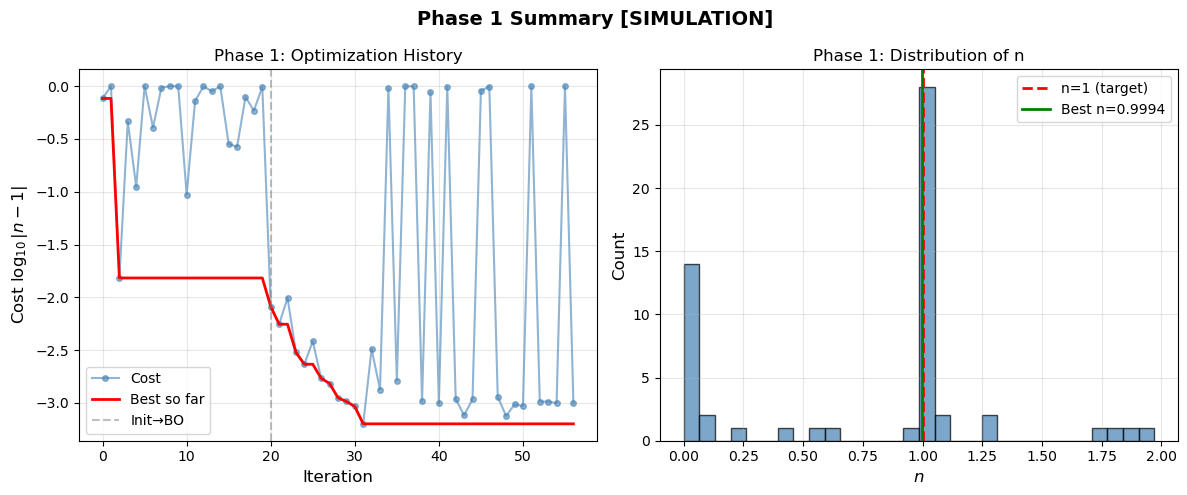

Saved: experiment_outputs_v2/phase1_summary_20260131_083923.png


In [10]:
# Cell 10: RUN PHASE 1 - OPTIMIZATION

# Initialize
config = Config()
config.output_dir.mkdir(parents=True, exist_ok=True)

# Connect to instruments
instr = InstrumentController(config)
print(f'\nMode: {instr.get_mode_string()}')

# Run Phase 1
phase1_results = run_phase1_optimization(instr, config)

# Display results
display_phase1_results(phase1_results, config)

# Quick plot
fig1 = plot_phase1_summary(phase1_results, instr, config)

In [11]:
# Cell 11: USER CONFIRMATION - BREAK POINT
#
# ╔════════════════════════════════════════════════════════════════╗
# ║  This cell PAUSES execution and waits for your confirmation!   ║
# ║  Execution will NOT continue until you respond.                ║
# ╚════════════════════════════════════════════════════════════════╝

print('='*70)
print('PHASE 1 COMPLETE - AWAITING USER CONFIRMATION')
print('='*70)
print(f'\nBest point found:')
print(f'  V_ENT*  = {phase1_results["best_V_ent"]:.6f} V')
print(f'  V_P*    = {phase1_results["best_V_p"]:.6f} V')
print(f'  V_EXIT* = {phase1_results["best_V_exit"]:.6f} V')
print(f'  n       = {phase1_results["best_n"]:.6f}')
print(f'  |n-1|   = {np.abs(phase1_results["best_n"]-1):.2e}')
print(f'\nProposed mapping ranges (centered on best point):')
V_ent_min = phase1_results["best_V_ent"] - config.MAPPING_RANGE_V_ENT/2
V_ent_max = phase1_results["best_V_ent"] + config.MAPPING_RANGE_V_ENT/2
V_exit_min = phase1_results["best_V_exit"] - config.MAPPING_RANGE_V_EXIT/2
V_exit_max = phase1_results["best_V_exit"] + config.MAPPING_RANGE_V_EXIT/2
print(f'  V_ENT:  [{V_ent_min:.3f}, {V_ent_max:.3f}] V  (±{config.MAPPING_RANGE_V_ENT/2:.3f} V)')
print(f'  V_EXIT: [{V_exit_min:.3f}, {V_exit_max:.3f}] V  (±{config.MAPPING_RANGE_V_EXIT/2:.3f} V)')
print(f'  Fixed V_P = {phase1_results["best_V_p"]:.4f} V')
print('='*70)

# ============================================================
# INTERACTIVE BREAK - Execution pauses here!
# ============================================================
print('\n╔' + '═'*62 + '╗')
print('║' + ' '*22 + 'DECISION REQUIRED' + ' '*23 + '║')
print('╠' + '═'*62 + '╣')
print('║  Enter "y" or "yes" → Proceed to Phase 2 (Mapping)          ║')
print('║  Enter "n" or "no"  → Stop here (Phase 1 complete)          ║')
print('║  Enter "a"          → Adjust parameters first               ║')
print('╚' + '═'*62 + '╝')

PROCEED_TO_PHASE2 = False

while True:
    response = input('\n>>> Proceed to Phase 2 mapping? [y/n/a]: ').strip().lower()
    
    if response in ['y', 'yes']:
        PROCEED_TO_PHASE2 = True
        print('\n✅ Confirmed - Proceeding to Phase 2 mapping...')
        break
    elif response in ['n', 'no']:
        PROCEED_TO_PHASE2 = False
        print('\n⏹️  Experiment stopped after Phase 1')
        print('    Your Phase 1 results are displayed above.')
        print('    To save data, run the save cells manually.')
        break
    elif response in ['a', 'adjust']:
        PROCEED_TO_PHASE2 = False
        print('\n⚙️  Adjustment mode:')
        print('    1. Go to Cell 2 and modify:')
        print('       - MAPPING_RANGE_V_ENT (currently {:.3f} V)'.format(config.MAPPING_RANGE_V_ENT))
        print('       - MAPPING_RANGE_V_EXIT (currently {:.3f} V)'.format(config.MAPPING_RANGE_V_EXIT))
        print('    2. Re-run Cell 2 to apply changes')
        print('    3. Re-run this cell (Cell 11) to see updated ranges')
        break
    else:
        print('    ⚠️  Invalid input. Please enter y, n, or a')

print('='*70)

PHASE 1 COMPLETE - AWAITING USER CONFIRMATION

Best point found:
  V_ENT*  = -0.618413 V
  V_P*    = -0.630823 V
  V_EXIT* = -0.682473 V
  n       = 0.999367
  |n-1|   = 6.33e-04

Proposed mapping ranges (centered on best point):
  V_ENT:  [-0.693, -0.543] V  (±0.075 V)
  V_EXIT: [-0.882, -0.482] V  (±0.200 V)
  Fixed V_P = -0.6308 V

╔══════════════════════════════════════════════════════════════╗
║                      DECISION REQUIRED                       ║
╠══════════════════════════════════════════════════════════════╣
║  Enter "y" or "yes" → Proceed to Phase 2 (Mapping)          ║
║  Enter "n" or "no"  → Stop here (Phase 1 complete)          ║
║  Enter "a"          → Adjust parameters first               ║
╚══════════════════════════════════════════════════════════════╝



>>> Proceed to Phase 2 mapping? [y/n/a]:  y



✅ Confirmed - Proceeding to Phase 2 mapping...


In [12]:
# Cell 12: RUN PHASE 2 - MAPPING
#
# This cell checks if you confirmed to proceed in Cell 11.

if not PROCEED_TO_PHASE2:
    print('='*70)
    print('⏹️  Phase 2 SKIPPED (you selected "n" or "a" in Cell 11)')
    print('='*70)
    print('\nTo run Phase 2:')
    print('  1. Go back to Cell 11')
    print('  2. Enter "y" when prompted')
    print('  3. Then run this cell again')
else:
    print('\n>>> Starting Phase 2: Efficient Mapping <<<\n')
    
    # Run Phase 2
    phase2_results = run_phase2_mapping(instr, phase1_results, config)
    
    print('\n✅ Phase 2 complete!')


>>> Starting Phase 2: Efficient Mapping <<<


PHASE 2: EFFICIENT MAPPING
Mapping pump characteristics around optimum

Mapping parameters:
  Center V_ENT:  -0.6184 V
  Center V_EXIT: -0.6825 V
  Fixed V_P:     -0.6308 V
  V_ENT range:   [-0.693, -0.543] V  (total 0.150 V)
  V_EXIT range:  [-0.882, -0.482] V  (total 0.400 V)

Phase 2a: Latin Hypercube Sampling (30 points)
--------------------------------------------------
  LHS  10/30: V_ENT=-0.693V, V_EXIT=-0.544V, n=1.8779
  LHS  20/30: V_ENT=-0.565V, V_EXIT=-0.718V, n=0.9469
  LHS  30/30: V_ENT=-0.659V, V_EXIT=-0.497V, n=1.9941
  GP fitted with 30 points

Phase 2b: Adaptive Uncertainty Sampling (70 points)
--------------------------------------------------
  Adaptive  10/70: V_ENT=-0.551V, V_EXIT=-0.484V, n=1.9121, mean_σ=0.1399
  Adaptive  20/70: V_ENT=-0.574V, V_EXIT=-0.486V, n=1.9901, mean_σ=0.0560
  Adaptive  30/70: V_ENT=-0.615V, V_EXIT=-0.589V, n=1.9984, mean_σ=0.0485
  Adaptive  40/70: V_ENT=-0.572V, V_EXIT=-0.539V, n=1.9880, 

Generating Phase 2 pump map analysis...


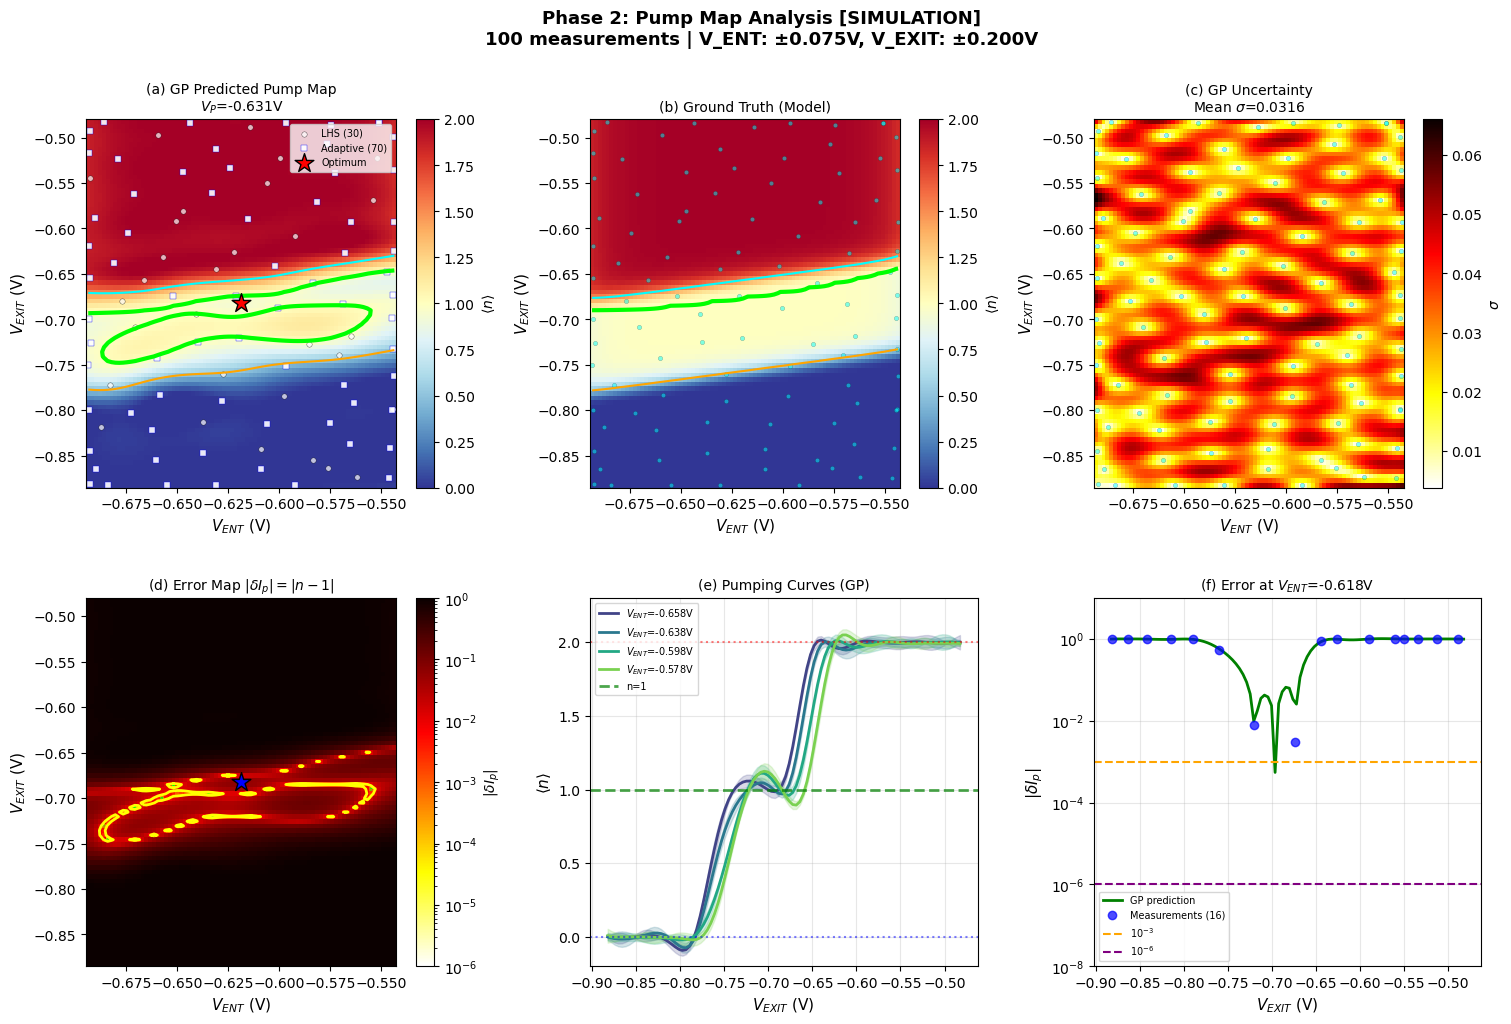

Saved: experiment_outputs_v2/phase2_pump_maps_20260131_083949.png

Generating combined summary...


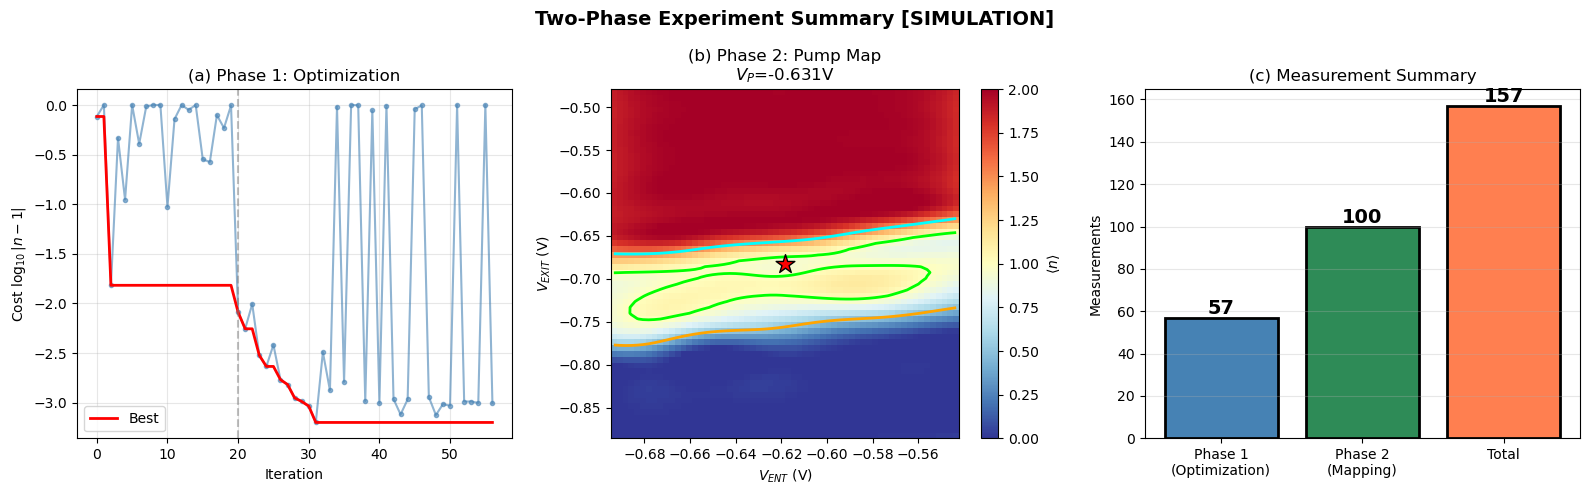

Saved: experiment_outputs_v2/combined_summary_20260131_083950.png


In [13]:
# Cell 13: Generate Phase 2 Visualizations

if not PROCEED_TO_PHASE2:
    print('⏹️  Skipped - Phase 2 was not executed')
else:
    print('Generating Phase 2 pump map analysis...')
    fig2 = plot_phase2_maps(phase2_results, instr, config)

    print('\nGenerating combined summary...')
    fig3 = plot_combined_summary(phase1_results, phase2_results, instr, config)

In [14]:
# Cell 14: Save All Data

if not PROCEED_TO_PHASE2:
    print('⏹️  Phase 2 was not executed')
    print('\nSaving Phase 1 data only...')
    
    # Save Phase 1 data
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    config.output_dir.mkdir(parents=True, exist_ok=True)
    
    X1 = phase1_results['X_hist']
    df1 = pd.DataFrame({
        'iteration': np.arange(len(X1)),
        'phase': 'optimization',
        'V_ENT': X1[:, 0],
        'V_P': X1[:, 1],
        'V_EXIT': X1[:, 2],
        'n': phase1_results['n_hist'],
        'cost': phase1_results['y_hist']
    })
    path1 = config.output_dir / f'phase1_optimization_{timestamp}.csv'
    df1.to_csv(path1, index=False)
    print(f'Saved: {path1}')
    
    # Summary
    summary = pd.DataFrame({
        'Parameter': ['best_V_ENT', 'best_V_P', 'best_V_EXIT', 'best_n', 'best_cost', 'phase1_measurements'],
        'Value': [phase1_results['best_V_ent'], phase1_results['best_V_p'], phase1_results['best_V_exit'],
                  phase1_results['best_n'], phase1_results['best_cost'], len(X1)]
    })
    path_summary = config.output_dir / f'phase1_summary_{timestamp}.csv'
    summary.to_csv(path_summary, index=False)
    print(f'Saved: {path_summary}')
    
    print('\n--- Phase 1 Data Preview ---')
    print(df1.head())
else:
    df1, df2, summary = save_all_data(phase1_results, phase2_results, config)

    print('\n--- Phase 1 Data Preview ---')
    print(df1.head())

    print('\n--- Phase 2 Data Preview ---')
    print(df2.head())

    print('\n--- Summary ---')
    print(summary)

Saved: experiment_outputs_v2/phase1_optimization_20260131_083950.csv
Saved: experiment_outputs_v2/phase2_mapping_20260131_083950.csv
Saved: experiment_outputs_v2/experiment_summary_20260131_083950.csv

--- Phase 1 Data Preview ---
   iteration         phase     V_ENT       V_P    V_EXIT         n      cost
0          0  optimization -0.674807 -0.504901 -0.586257  0.234074 -0.115813
1          1  optimization -0.549274 -0.718808 -0.786558 -0.000074  0.000032
2          2  optimization -0.657802 -0.666883 -0.731636  0.984752 -1.816774
3          3  optimization -0.618676 -0.517419 -0.593540  0.535243 -0.332774
4          4  optimization -0.640147 -0.688452 -0.671119  1.111217 -0.953830

--- Phase 2 Data Preview ---
   iteration    phase     V_ENT       V_P    V_EXIT         n
0          0  mapping -0.592283 -0.630823 -0.608325  1.992695
1          1  mapping -0.682706 -0.630823 -0.771771  0.644683
2          2  mapping -0.608884 -0.630823 -0.842148 -0.000079
3          3  mapping -0.6372

In [15]:
# Cell 15: Final Summary & Cleanup

print('\n' + '='*70)
print('EXPERIMENT COMPLETE - FINAL SUMMARY')
print('='*70)
print(f'\nMode: {instr.get_mode_string()}')
print(f'\n--- Phase 1: Optimization ---')
print(f'  Measurements: {len(phase1_results["y_hist"])}')
print(f'  Best V_ENT:   {phase1_results["best_V_ent"]:.6f} V')
print(f'  Best V_P:     {phase1_results["best_V_p"]:.6f} V')
print(f'  Best V_EXIT:  {phase1_results["best_V_exit"]:.6f} V')
print(f'  Best n:       {phase1_results["best_n"]:.6f}')
print(f'  Best |n-1|:   {np.abs(phase1_results["best_n"]-1):.2e}')

if PROCEED_TO_PHASE2:
    print(f'\n--- Phase 2: Mapping ---')
    print(f'  Measurements: {len(phase2_results["X_measured"])}')
    print(f'  Fixed V_P:    {phase2_results["V_p_fixed"]:.6f} V')
    print(f'  V_ENT range:  [{phase2_results["bounds_2d"][0,0]:.3f}, {phase2_results["bounds_2d"][0,1]:.3f}] V')
    print(f'  V_EXIT range: [{phase2_results["bounds_2d"][1,0]:.3f}, {phase2_results["bounds_2d"][1,1]:.3f}] V')
    print(f'\n--- Total ---')
    print(f'  Total measurements: {len(phase1_results["y_hist"]) + len(phase2_results["X_measured"])}')
else:
    print(f'\n--- Phase 2: SKIPPED ---')
    print(f'\n--- Total ---')
    print(f'  Total measurements: {len(phase1_results["y_hist"])} (Phase 1 only)')

print(f'\n--- Output Files ---')
print(f'  Directory: {config.output_dir}')
for f in sorted(config.output_dir.glob('*')):
    print(f'    {f.name}')
print('='*70)

# Close instruments
instr.close()


EXPERIMENT COMPLETE - FINAL SUMMARY

Mode: SIMULATION

--- Phase 1: Optimization ---
  Measurements: 57
  Best V_ENT:   -0.618413 V
  Best V_P:     -0.630823 V
  Best V_EXIT:  -0.682473 V
  Best n:       0.999367
  Best |n-1|:   6.33e-04

--- Phase 2: Mapping ---
  Measurements: 100
  Fixed V_P:    -0.630823 V
  V_ENT range:  [-0.693, -0.543] V
  V_EXIT range: [-0.882, -0.482] V

--- Total ---
  Total measurements: 157

--- Output Files ---
  Directory: experiment_outputs_v2
    combined_summary_20260131_080332.png
    combined_summary_20260131_083049.png
    combined_summary_20260131_083950.png
    experiment_summary_20260131_080332.csv
    experiment_summary_20260131_083049.csv
    experiment_summary_20260131_083950.csv
    phase1_optimization_20260131_080332.csv
    phase1_optimization_20260131_083049.csv
    phase1_optimization_20260131_083950.csv
    phase1_summary_20260131_080322.png
    phase1_summary_20260131_083037.png
    phase1_summary_20260131_083923.png
    phase2_mapping